In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 512)               425984    


 dense_1 (Dense)             (None, 256)               131328    


 dense_2 (Dense)             (None, 128)               32896     


 dense_3 (Dense)             (None, 8)                 1032      


Total params: 591240 (2.26 MB)


Trainable params: 591240 (2.26 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:19 - loss: 1.9880 - STD: 0.0840 - MAE: 0.2106

 5/78 [>.............................] - ETA: 0s - loss: 1.5782 - STD: 0.1568 - MAE: 0.1656  

 9/78 [==>...........................] - ETA: 0s - loss: 1.4840 - STD: 0.1911 - MAE: 0.1496

12/78 [===>..........................] - ETA: 1s - loss: 1.4431 - STD: 0.1900 - MAE: 0.1489

16/78 [=====>........................] - ETA: 0s - loss: 1.4189 - STD: 0.1857 - MAE: 0.1501

20/78 [======>.......................] - ETA: 2s - loss: 1.4020 - STD: 0.1886 - MAE: 0.1484

25/78 [========>.....................] - ETA: 1s - loss: 1.3859 - STD: 0.1929 - MAE: 0.1463

29/78 [==========>...................] - ETA: 1s - loss: 1.3744 - STD: 0.1927 - MAE: 0.1461

33/78 [===========>..................] - ETA: 1s - loss: 1.3672 - STD: 0.1914 - MAE: 0.1465

37/78 [=============>................] - ETA: 1s - loss: 1.3601 - STD: 0.1911 - MAE: 0.1464

41/78 [==============>...............] - ETA: 0s - loss: 1.3542 - STD: 0.1917 - MAE: 0.1460

45/78 [================>.............] - ETA: 0s - loss: 1.3485 - STD: 0.1919 - MAE: 0.1457

49/78 [=================>............] - ETA: 0s - loss: 1.3435 - STD: 0.1915 - MAE: 0.1457

53/78 [===================>..........] - ETA: 0s - loss: 1.3393 - STD: 0.1913 - MAE: 0.1457

57/78 [====================>.........] - ETA: 0s - loss: 1.3350 - STD: 0.1914 - MAE: 0.1455

58/78 [=====================>........] - ETA: 0s - loss: 1.3342 - STD: 0.1914 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3295 - STD: 0.1914 - MAE: 0.1453

66/78 [========================>.....] - ETA: 0s - loss: 1.3252 - STD: 0.1918 - MAE: 0.1450

70/78 [=========================>....] - ETA: 0s - loss: 1.3208 - STD: 0.1921 - MAE: 0.1447

74/78 [===========================>..] - ETA: 0s - loss: 1.3165 - STD: 0.1923 - MAE: 0.1445

78/78 [==============================] - ETA: 0s - loss: 1.3127 - STD: 0.1927 - MAE: 0.1442

78/78 [==============================] - 3s 29ms/step - loss: 1.3127 - STD: 0.1927 - MAE: 0.1442 - val_loss: 1.1795 - val_STD: 0.1942 - val_MAE: 0.1393


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.2224 - STD: 0.1973 - MAE: 0.1393

 4/78 [>.............................] - ETA: 1s - loss: 1.2265 - STD: 0.1977 - MAE: 0.1395

 8/78 [==>...........................] - ETA: 1s - loss: 1.2262 - STD: 0.1976 - MAE: 0.1396

12/78 [===>..........................] - ETA: 0s - loss: 1.2222 - STD: 0.1978 - MAE: 0.1395

16/78 [=====>........................] - ETA: 0s - loss: 1.2168 - STD: 0.1981 - MAE: 0.1391

20/78 [======>.......................] - ETA: 0s - loss: 1.2110 - STD: 0.1985 - MAE: 0.1387

24/78 [========>.....................] - ETA: 0s - loss: 1.2056 - STD: 0.1988 - MAE: 0.1385

28/78 [=========>....................] - ETA: 0s - loss: 1.2017 - STD: 0.1989 - MAE: 0.1383

32/78 [===========>..................] - ETA: 0s - loss: 1.1978 - STD: 0.1991 - MAE: 0.1381

36/78 [============>.................] - ETA: 0s - loss: 1.1937 - STD: 0.1994 - MAE: 0.1378

40/78 [==============>...............] - ETA: 0s - loss: 1.1882 - STD: 0.1996 - MAE: 0.1375

44/78 [===============>..............] - ETA: 0s - loss: 1.1853 - STD: 0.1997 - MAE: 0.1375

48/78 [=================>............] - ETA: 0s - loss: 1.1806 - STD: 0.1999 - MAE: 0.1372

52/78 [===================>..........] - ETA: 0s - loss: 1.1760 - STD: 0.2002 - MAE: 0.1369

56/78 [====================>.........] - ETA: 0s - loss: 1.1719 - STD: 0.2002 - MAE: 0.1368

60/78 [======================>.......] - ETA: 0s - loss: 1.1672 - STD: 0.2005 - MAE: 0.1365

64/78 [=======================>......] - ETA: 0s - loss: 1.1626 - STD: 0.2007 - MAE: 0.1363

68/78 [=========================>....] - ETA: 0s - loss: 1.1573 - STD: 0.2009 - MAE: 0.1360

73/78 [===========================>..] - ETA: 0s - loss: 1.1516 - STD: 0.2012 - MAE: 0.1357

77/78 [============================>.] - ETA: 0s - loss: 1.1461 - STD: 0.2016 - MAE: 0.1353

78/78 [==============================] - 1s 16ms/step - loss: 1.1446 - STD: 0.2016 - MAE: 0.1352 - val_loss: 1.0267 - val_STD: 0.2046 - val_MAE: 0.1300


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0451 - STD: 0.2061 - MAE: 0.1300

 5/78 [>.............................] - ETA: 1s - loss: 1.0330 - STD: 0.2079 - MAE: 0.1288

 9/78 [==>...........................] - ETA: 0s - loss: 1.0257 - STD: 0.2097 - MAE: 0.1276

13/78 [====>.........................] - ETA: 0s - loss: 1.0230 - STD: 0.2100 - MAE: 0.1274

17/78 [=====>........................] - ETA: 0s - loss: 1.0176 - STD: 0.2109 - MAE: 0.1267

21/78 [=======>......................] - ETA: 0s - loss: 1.0138 - STD: 0.2114 - MAE: 0.1264

25/78 [========>.....................] - ETA: 0s - loss: 1.0100 - STD: 0.2114 - MAE: 0.1262

29/78 [==========>...................] - ETA: 0s - loss: 1.0055 - STD: 0.2117 - MAE: 0.1259

33/78 [===========>..................] - ETA: 0s - loss: 1.0015 - STD: 0.2123 - MAE: 0.1255

38/78 [=============>................] - ETA: 0s - loss: 0.9980 - STD: 0.2126 - MAE: 0.1253

42/78 [===============>..............] - ETA: 0s - loss: 0.9936 - STD: 0.2130 - MAE: 0.1250

46/78 [================>.............] - ETA: 0s - loss: 0.9895 - STD: 0.2135 - MAE: 0.1246

50/78 [==================>...........] - ETA: 0s - loss: 0.9857 - STD: 0.2140 - MAE: 0.1242

54/78 [===================>..........] - ETA: 0s - loss: 0.9824 - STD: 0.2144 - MAE: 0.1239

58/78 [=====================>........] - ETA: 0s - loss: 0.9790 - STD: 0.2146 - MAE: 0.1237

62/78 [======================>.......] - ETA: 0s - loss: 0.9756 - STD: 0.2150 - MAE: 0.1234

66/78 [========================>.....] - ETA: 0s - loss: 0.9726 - STD: 0.2154 - MAE: 0.1231

70/78 [=========================>....] - ETA: 0s - loss: 0.9695 - STD: 0.2158 - MAE: 0.1228

74/78 [===========================>..] - ETA: 0s - loss: 0.9665 - STD: 0.2161 - MAE: 0.1226

78/78 [==============================] - ETA: 0s - loss: 0.9637 - STD: 0.2164 - MAE: 0.1223

78/78 [==============================] - 1s 17ms/step - loss: 0.9637 - STD: 0.2164 - MAE: 0.1223 - val_loss: 0.9144 - val_STD: 0.2233 - val_MAE: 0.1177


Epoch 4/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9232 - STD: 0.2248 - MAE: 0.1174

 5/78 [>.............................] - ETA: 1s - loss: 0.9125 - STD: 0.2229 - MAE: 0.1176

 9/78 [==>...........................] - ETA: 1s - loss: 0.9106 - STD: 0.2224 - MAE: 0.1175

13/78 [====>.........................] - ETA: 0s - loss: 0.9096 - STD: 0.2225 - MAE: 0.1174

17/78 [=====>........................] - ETA: 0s - loss: 0.9083 - STD: 0.2228 - MAE: 0.1173

21/78 [=======>......................] - ETA: 0s - loss: 0.9077 - STD: 0.2230 - MAE: 0.1171

25/78 [========>.....................] - ETA: 0s - loss: 0.9055 - STD: 0.2234 - MAE: 0.1168

29/78 [==========>...................] - ETA: 0s - loss: 0.9046 - STD: 0.2235 - MAE: 0.1168

34/78 [============>.................] - ETA: 0s - loss: 0.9035 - STD: 0.2238 - MAE: 0.1166

38/78 [=============>................] - ETA: 0s - loss: 0.9018 - STD: 0.2238 - MAE: 0.1165

42/78 [===============>..............] - ETA: 0s - loss: 0.9011 - STD: 0.2239 - MAE: 0.1164

46/78 [================>.............] - ETA: 0s - loss: 0.9003 - STD: 0.2241 - MAE: 0.1163

50/78 [==================>...........] - ETA: 0s - loss: 0.8995 - STD: 0.2241 - MAE: 0.1163

54/78 [===================>..........] - ETA: 0s - loss: 0.8983 - STD: 0.2242 - MAE: 0.1162

58/78 [=====================>........] - ETA: 0s - loss: 0.8971 - STD: 0.2244 - MAE: 0.1161

62/78 [======================>.......] - ETA: 0s - loss: 0.8964 - STD: 0.2245 - MAE: 0.1160

66/78 [========================>.....] - ETA: 0s - loss: 0.8957 - STD: 0.2246 - MAE: 0.1159

70/78 [=========================>....] - ETA: 0s - loss: 0.8947 - STD: 0.2248 - MAE: 0.1158

74/78 [===========================>..] - ETA: 0s - loss: 0.8937 - STD: 0.2249 - MAE: 0.1157

78/78 [==============================] - ETA: 0s - loss: 0.8931 - STD: 0.2250 - MAE: 0.1156

78/78 [==============================] - 1s 17ms/step - loss: 0.8931 - STD: 0.2250 - MAE: 0.1156 - val_loss: 0.8994 - val_STD: 0.2297 - val_MAE: 0.1136


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8862 - STD: 0.2328 - MAE: 0.1117

 5/78 [>.............................] - ETA: 0s - loss: 0.8770 - STD: 0.2293 - MAE: 0.1129

 9/78 [==>...........................] - ETA: 0s - loss: 0.8750 - STD: 0.2287 - MAE: 0.1131

13/78 [====>.........................] - ETA: 0s - loss: 0.8768 - STD: 0.2286 - MAE: 0.1132

18/78 [=====>........................] - ETA: 0s - loss: 0.8748 - STD: 0.2282 - MAE: 0.1133

22/78 [=======>......................] - ETA: 0s - loss: 0.8749 - STD: 0.2281 - MAE: 0.1133

26/78 [=========>....................] - ETA: 0s - loss: 0.8738 - STD: 0.2281 - MAE: 0.1133

30/78 [==========>...................] - ETA: 0s - loss: 0.8734 - STD: 0.2282 - MAE: 0.1132

34/78 [============>.................] - ETA: 0s - loss: 0.8729 - STD: 0.2282 - MAE: 0.1132

38/78 [=============>................] - ETA: 0s - loss: 0.8724 - STD: 0.2282 - MAE: 0.1132

42/78 [===============>..............] - ETA: 0s - loss: 0.8715 - STD: 0.2282 - MAE: 0.1131

46/78 [================>.............] - ETA: 0s - loss: 0.8707 - STD: 0.2283 - MAE: 0.1130

50/78 [==================>...........] - ETA: 0s - loss: 0.8699 - STD: 0.2285 - MAE: 0.1129

54/78 [===================>..........] - ETA: 0s - loss: 0.8698 - STD: 0.2286 - MAE: 0.1129

58/78 [=====================>........] - ETA: 0s - loss: 0.8688 - STD: 0.2286 - MAE: 0.1128

62/78 [======================>.......] - ETA: 0s - loss: 0.8682 - STD: 0.2286 - MAE: 0.1128

66/78 [========================>.....] - ETA: 0s - loss: 0.8673 - STD: 0.2288 - MAE: 0.1127

70/78 [=========================>....] - ETA: 0s - loss: 0.8666 - STD: 0.2288 - MAE: 0.1126

74/78 [===========================>..] - ETA: 0s - loss: 0.8658 - STD: 0.2289 - MAE: 0.1126

78/78 [==============================] - 1s 15ms/step - loss: 0.8654 - STD: 0.2289 - MAE: 0.1125 - val_loss: 0.8512 - val_STD: 0.2248 - val_MAE: 0.1138


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8567 - STD: 0.2276 - MAE: 0.1126

 5/78 [>.............................] - ETA: 1s - loss: 0.8589 - STD: 0.2295 - MAE: 0.1119

 9/78 [==>...........................] - ETA: 1s - loss: 0.8613 - STD: 0.2300 - MAE: 0.1119

13/78 [====>.........................] - ETA: 0s - loss: 0.8571 - STD: 0.2302 - MAE: 0.1115

17/78 [=====>........................] - ETA: 0s - loss: 0.8563 - STD: 0.2301 - MAE: 0.1116

21/78 [=======>......................] - ETA: 0s - loss: 0.8548 - STD: 0.2303 - MAE: 0.1114

25/78 [========>.....................] - ETA: 0s - loss: 0.8530 - STD: 0.2306 - MAE: 0.1111

30/78 [==========>...................] - ETA: 0s - loss: 0.8527 - STD: 0.2308 - MAE: 0.1111

34/78 [============>.................] - ETA: 0s - loss: 0.8518 - STD: 0.2308 - MAE: 0.1111

38/78 [=============>................] - ETA: 0s - loss: 0.8504 - STD: 0.2307 - MAE: 0.1110

42/78 [===============>..............] - ETA: 0s - loss: 0.8502 - STD: 0.2308 - MAE: 0.1110

46/78 [================>.............] - ETA: 0s - loss: 0.8494 - STD: 0.2309 - MAE: 0.1109

50/78 [==================>...........] - ETA: 0s - loss: 0.8486 - STD: 0.2310 - MAE: 0.1108

54/78 [===================>..........] - ETA: 0s - loss: 0.8482 - STD: 0.2311 - MAE: 0.1107

58/78 [=====================>........] - ETA: 0s - loss: 0.8483 - STD: 0.2312 - MAE: 0.1107

62/78 [======================>.......] - ETA: 0s - loss: 0.8479 - STD: 0.2313 - MAE: 0.1106

66/78 [========================>.....] - ETA: 0s - loss: 0.8468 - STD: 0.2314 - MAE: 0.1105

70/78 [=========================>....] - ETA: 0s - loss: 0.8463 - STD: 0.2314 - MAE: 0.1105

74/78 [===========================>..] - ETA: 0s - loss: 0.8460 - STD: 0.2315 - MAE: 0.1104

78/78 [==============================] - ETA: 0s - loss: 0.8460 - STD: 0.2314 - MAE: 0.1104

78/78 [==============================] - 1s 17ms/step - loss: 0.8460 - STD: 0.2314 - MAE: 0.1104 - val_loss: 0.8500 - val_STD: 0.2294 - val_MAE: 0.1113


Epoch 7/10000


 1/78 [..............................] - ETA: 2s - loss: 0.8457 - STD: 0.2330 - MAE: 0.1095

 4/78 [>.............................] - ETA: 1s - loss: 0.8407 - STD: 0.2323 - MAE: 0.1097

 8/78 [==>...........................] - ETA: 1s - loss: 0.8377 - STD: 0.2321 - MAE: 0.1096

12/78 [===>..........................] - ETA: 0s - loss: 0.8374 - STD: 0.2321 - MAE: 0.1097

17/78 [=====>........................] - ETA: 0s - loss: 0.8368 - STD: 0.2328 - MAE: 0.1094

21/78 [=======>......................] - ETA: 0s - loss: 0.8349 - STD: 0.2330 - MAE: 0.1092

25/78 [========>.....................] - ETA: 0s - loss: 0.8344 - STD: 0.2330 - MAE: 0.1091

29/78 [==========>...................] - ETA: 0s - loss: 0.8338 - STD: 0.2331 - MAE: 0.1091

33/78 [===========>..................] - ETA: 0s - loss: 0.8330 - STD: 0.2332 - MAE: 0.1090

37/78 [=============>................] - ETA: 0s - loss: 0.8322 - STD: 0.2332 - MAE: 0.1089

41/78 [==============>...............] - ETA: 0s - loss: 0.8319 - STD: 0.2332 - MAE: 0.1089

44/78 [===============>..............] - ETA: 0s - loss: 0.8310 - STD: 0.2332 - MAE: 0.1089

48/78 [=================>............] - ETA: 0s - loss: 0.8309 - STD: 0.2332 - MAE: 0.1089

52/78 [===================>..........] - ETA: 0s - loss: 0.8308 - STD: 0.2332 - MAE: 0.1089

56/78 [====================>.........] - ETA: 0s - loss: 0.8299 - STD: 0.2333 - MAE: 0.1088

60/78 [======================>.......] - ETA: 0s - loss: 0.8296 - STD: 0.2333 - MAE: 0.1088

64/78 [=======================>......] - ETA: 0s - loss: 0.8290 - STD: 0.2334 - MAE: 0.1087

68/78 [=========================>....] - ETA: 0s - loss: 0.8285 - STD: 0.2335 - MAE: 0.1086

72/78 [==========================>...] - ETA: 0s - loss: 0.8284 - STD: 0.2335 - MAE: 0.1086

76/78 [============================>.] - ETA: 0s - loss: 0.8279 - STD: 0.2335 - MAE: 0.1086

78/78 [==============================] - 1s 17ms/step - loss: 0.8280 - STD: 0.2334 - MAE: 0.1086 - val_loss: 0.8252 - val_STD: 0.2290 - val_MAE: 0.1105


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8302 - STD: 0.2318 - MAE: 0.1094

 4/78 [>.............................] - ETA: 1s - loss: 0.8171 - STD: 0.2342 - MAE: 0.1076

 8/78 [==>...........................] - ETA: 1s - loss: 0.8209 - STD: 0.2337 - MAE: 0.1081

12/78 [===>..........................] - ETA: 1s - loss: 0.8202 - STD: 0.2339 - MAE: 0.1080

16/78 [=====>........................] - ETA: 0s - loss: 0.8198 - STD: 0.2342 - MAE: 0.1078

20/78 [======>.......................] - ETA: 0s - loss: 0.8182 - STD: 0.2343 - MAE: 0.1077

24/78 [========>.....................] - ETA: 0s - loss: 0.8170 - STD: 0.2344 - MAE: 0.1076

28/78 [=========>....................] - ETA: 0s - loss: 0.8163 - STD: 0.2345 - MAE: 0.1076

32/78 [===========>..................] - ETA: 0s - loss: 0.8173 - STD: 0.2344 - MAE: 0.1077

36/78 [============>.................] - ETA: 0s - loss: 0.8173 - STD: 0.2345 - MAE: 0.1076

40/78 [==============>...............] - ETA: 0s - loss: 0.8173 - STD: 0.2347 - MAE: 0.1075

45/78 [================>.............] - ETA: 0s - loss: 0.8165 - STD: 0.2347 - MAE: 0.1075

49/78 [=================>............] - ETA: 0s - loss: 0.8166 - STD: 0.2348 - MAE: 0.1075

53/78 [===================>..........] - ETA: 0s - loss: 0.8163 - STD: 0.2348 - MAE: 0.1074

57/78 [====================>.........] - ETA: 0s - loss: 0.8152 - STD: 0.2350 - MAE: 0.1073

61/78 [======================>.......] - ETA: 0s - loss: 0.8149 - STD: 0.2351 - MAE: 0.1072

65/78 [========================>.....] - ETA: 0s - loss: 0.8146 - STD: 0.2351 - MAE: 0.1072

69/78 [=========================>....] - ETA: 0s - loss: 0.8144 - STD: 0.2351 - MAE: 0.1072

73/78 [===========================>..] - ETA: 0s - loss: 0.8143 - STD: 0.2352 - MAE: 0.1072

77/78 [============================>.] - ETA: 0s - loss: 0.8136 - STD: 0.2352 - MAE: 0.1071

78/78 [==============================] - 1s 17ms/step - loss: 0.8134 - STD: 0.2352 - MAE: 0.1071 - val_loss: 0.8085 - val_STD: 0.2267 - val_MAE: 0.1112


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7982 - STD: 0.2304 - MAE: 0.1086

 4/78 [>.............................] - ETA: 1s - loss: 0.8042 - STD: 0.2353 - MAE: 0.1066

 8/78 [==>...........................] - ETA: 1s - loss: 0.8073 - STD: 0.2351 - MAE: 0.1069

12/78 [===>..........................] - ETA: 1s - loss: 0.8051 - STD: 0.2354 - MAE: 0.1066

16/78 [=====>........................] - ETA: 0s - loss: 0.8060 - STD: 0.2355 - MAE: 0.1066

20/78 [======>.......................] - ETA: 0s - loss: 0.8051 - STD: 0.2355 - MAE: 0.1065

24/78 [========>.....................] - ETA: 0s - loss: 0.8036 - STD: 0.2357 - MAE: 0.1063

28/78 [=========>....................] - ETA: 0s - loss: 0.8027 - STD: 0.2359 - MAE: 0.1062

32/78 [===========>..................] - ETA: 0s - loss: 0.8017 - STD: 0.2360 - MAE: 0.1061

36/78 [============>.................] - ETA: 0s - loss: 0.8007 - STD: 0.2361 - MAE: 0.1060

40/78 [==============>...............] - ETA: 0s - loss: 0.8000 - STD: 0.2361 - MAE: 0.1060

44/78 [===============>..............] - ETA: 0s - loss: 0.7999 - STD: 0.2362 - MAE: 0.1060

48/78 [=================>............] - ETA: 0s - loss: 0.8000 - STD: 0.2362 - MAE: 0.1060

52/78 [===================>..........] - ETA: 0s - loss: 0.8003 - STD: 0.2362 - MAE: 0.1060

56/78 [====================>.........] - ETA: 0s - loss: 0.7995 - STD: 0.2362 - MAE: 0.1060

60/78 [======================>.......] - ETA: 0s - loss: 0.7993 - STD: 0.2364 - MAE: 0.1059

64/78 [=======================>......] - ETA: 0s - loss: 0.8001 - STD: 0.2363 - MAE: 0.1060

68/78 [=========================>....] - ETA: 0s - loss: 0.7998 - STD: 0.2365 - MAE: 0.1059

72/78 [==========================>...] - ETA: 0s - loss: 0.7991 - STD: 0.2366 - MAE: 0.1058

77/78 [============================>.] - ETA: 0s - loss: 0.7987 - STD: 0.2367 - MAE: 0.1057

78/78 [==============================] - 1s 17ms/step - loss: 0.7986 - STD: 0.2367 - MAE: 0.1057 - val_loss: 0.7951 - val_STD: 0.2299 - val_MAE: 0.1092


Epoch 10/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7820 - STD: 0.2334 - MAE: 0.1064

 5/78 [>.............................] - ETA: 1s - loss: 0.7876 - STD: 0.2366 - MAE: 0.1052

10/78 [==>...........................] - ETA: 0s - loss: 0.7880 - STD: 0.2369 - MAE: 0.1049

14/78 [====>.........................] - ETA: 0s - loss: 0.7896 - STD: 0.2369 - MAE: 0.1051

18/78 [=====>........................] - ETA: 0s - loss: 0.7921 - STD: 0.2367 - MAE: 0.1054

22/78 [=======>......................] - ETA: 0s - loss: 0.7925 - STD: 0.2369 - MAE: 0.1053

26/78 [=========>....................] - ETA: 0s - loss: 0.7920 - STD: 0.2370 - MAE: 0.1053

30/78 [==========>...................] - ETA: 0s - loss: 0.7919 - STD: 0.2371 - MAE: 0.1052

34/78 [============>.................] - ETA: 0s - loss: 0.7910 - STD: 0.2373 - MAE: 0.1051

38/78 [=============>................] - ETA: 0s - loss: 0.7904 - STD: 0.2374 - MAE: 0.1050

42/78 [===============>..............] - ETA: 0s - loss: 0.7900 - STD: 0.2373 - MAE: 0.1050

46/78 [================>.............] - ETA: 0s - loss: 0.7894 - STD: 0.2375 - MAE: 0.1049

50/78 [==================>...........] - ETA: 0s - loss: 0.7886 - STD: 0.2375 - MAE: 0.1049

54/78 [===================>..........] - ETA: 0s - loss: 0.7880 - STD: 0.2376 - MAE: 0.1048

58/78 [=====================>........] - ETA: 0s - loss: 0.7875 - STD: 0.2377 - MAE: 0.1047

62/78 [======================>.......] - ETA: 0s - loss: 0.7873 - STD: 0.2378 - MAE: 0.1047

66/78 [========================>.....] - ETA: 0s - loss: 0.7872 - STD: 0.2378 - MAE: 0.1047

70/78 [=========================>....] - ETA: 0s - loss: 0.7872 - STD: 0.2379 - MAE: 0.1046

74/78 [===========================>..] - ETA: 0s - loss: 0.7874 - STD: 0.2379 - MAE: 0.1046

78/78 [==============================] - ETA: 0s - loss: 0.7873 - STD: 0.2380 - MAE: 0.1046

78/78 [==============================] - 1s 16ms/step - loss: 0.7873 - STD: 0.2380 - MAE: 0.1046 - val_loss: 0.7880 - val_STD: 0.2306 - val_MAE: 0.1085


Epoch 11/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7798 - STD: 0.2344 - MAE: 0.1059

 5/78 [>.............................] - ETA: 1s - loss: 0.7914 - STD: 0.2382 - MAE: 0.1049

 9/78 [==>...........................] - ETA: 0s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1048

13/78 [====>.........................] - ETA: 0s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1048

17/78 [=====>........................] - ETA: 0s - loss: 0.7920 - STD: 0.2381 - MAE: 0.1050

21/78 [=======>......................] - ETA: 0s - loss: 0.7902 - STD: 0.2382 - MAE: 0.1048

25/78 [========>.....................] - ETA: 0s - loss: 0.7871 - STD: 0.2382 - MAE: 0.1046

29/78 [==========>...................] - ETA: 0s - loss: 0.7863 - STD: 0.2382 - MAE: 0.1046

33/78 [===========>..................] - ETA: 0s - loss: 0.7850 - STD: 0.2382 - MAE: 0.1045

37/78 [=============>................] - ETA: 0s - loss: 0.7837 - STD: 0.2382 - MAE: 0.1044

41/78 [==============>...............] - ETA: 0s - loss: 0.7830 - STD: 0.2383 - MAE: 0.1044

45/78 [================>.............] - ETA: 0s - loss: 0.7819 - STD: 0.2383 - MAE: 0.1043

48/78 [=================>............] - ETA: 0s - loss: 0.7818 - STD: 0.2384 - MAE: 0.1042

52/78 [===================>..........] - ETA: 0s - loss: 0.7811 - STD: 0.2385 - MAE: 0.1042

57/78 [====================>.........] - ETA: 0s - loss: 0.7801 - STD: 0.2385 - MAE: 0.1041

61/78 [======================>.......] - ETA: 0s - loss: 0.7795 - STD: 0.2386 - MAE: 0.1040

65/78 [========================>.....] - ETA: 0s - loss: 0.7792 - STD: 0.2387 - MAE: 0.1039

69/78 [=========================>....] - ETA: 0s - loss: 0.7790 - STD: 0.2387 - MAE: 0.1039

73/78 [===========================>..] - ETA: 0s - loss: 0.7785 - STD: 0.2388 - MAE: 0.1038

77/78 [============================>.] - ETA: 0s - loss: 0.7777 - STD: 0.2388 - MAE: 0.1038

78/78 [==============================] - 1s 16ms/step - loss: 0.7778 - STD: 0.2389 - MAE: 0.1037 - val_loss: 0.7763 - val_STD: 0.2335 - val_MAE: 0.1069


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7578 - STD: 0.2372 - MAE: 0.1037

 5/78 [>.............................] - ETA: 0s - loss: 0.7694 - STD: 0.2388 - MAE: 0.1033

 9/78 [==>...........................] - ETA: 0s - loss: 0.7680 - STD: 0.2390 - MAE: 0.1032

13/78 [====>.........................] - ETA: 0s - loss: 0.7664 - STD: 0.2393 - MAE: 0.1030

18/78 [=====>........................] - ETA: 0s - loss: 0.7676 - STD: 0.2396 - MAE: 0.1029

22/78 [=======>......................] - ETA: 0s - loss: 0.7699 - STD: 0.2398 - MAE: 0.1030

26/78 [=========>....................] - ETA: 0s - loss: 0.7706 - STD: 0.2397 - MAE: 0.1031

30/78 [==========>...................] - ETA: 0s - loss: 0.7699 - STD: 0.2396 - MAE: 0.1031

34/78 [============>.................] - ETA: 0s - loss: 0.7695 - STD: 0.2396 - MAE: 0.1030

38/78 [=============>................] - ETA: 0s - loss: 0.7701 - STD: 0.2396 - MAE: 0.1031

42/78 [===============>..............] - ETA: 0s - loss: 0.7697 - STD: 0.2397 - MAE: 0.1030

46/78 [================>.............] - ETA: 0s - loss: 0.7700 - STD: 0.2397 - MAE: 0.1030

50/78 [==================>...........] - ETA: 0s - loss: 0.7693 - STD: 0.2398 - MAE: 0.1030

54/78 [===================>..........] - ETA: 0s - loss: 0.7690 - STD: 0.2398 - MAE: 0.1029

58/78 [=====================>........] - ETA: 0s - loss: 0.7683 - STD: 0.2398 - MAE: 0.1028

62/78 [======================>.......] - ETA: 0s - loss: 0.7680 - STD: 0.2398 - MAE: 0.1028

66/78 [========================>.....] - ETA: 0s - loss: 0.7680 - STD: 0.2398 - MAE: 0.1028

70/78 [=========================>....] - ETA: 0s - loss: 0.7676 - STD: 0.2398 - MAE: 0.1028

74/78 [===========================>..] - ETA: 0s - loss: 0.7676 - STD: 0.2399 - MAE: 0.1028

78/78 [==============================] - ETA: 0s - loss: 0.7679 - STD: 0.2399 - MAE: 0.1028

78/78 [==============================] - 1s 15ms/step - loss: 0.7679 - STD: 0.2399 - MAE: 0.1028 - val_loss: 0.7882 - val_STD: 0.2428 - val_MAE: 0.1026


Epoch 13/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7597 - STD: 0.2471 - MAE: 0.0991

 4/78 [>.............................] - ETA: 1s - loss: 0.7639 - STD: 0.2410 - MAE: 0.1022

 8/78 [==>...........................] - ETA: 1s - loss: 0.7637 - STD: 0.2409 - MAE: 0.1021

12/78 [===>..........................] - ETA: 1s - loss: 0.7632 - STD: 0.2405 - MAE: 0.1023

16/78 [=====>........................] - ETA: 0s - loss: 0.7620 - STD: 0.2402 - MAE: 0.1024

20/78 [======>.......................] - ETA: 0s - loss: 0.7620 - STD: 0.2403 - MAE: 0.1023

24/78 [========>.....................] - ETA: 0s - loss: 0.7609 - STD: 0.2404 - MAE: 0.1022

28/78 [=========>....................] - ETA: 0s - loss: 0.7610 - STD: 0.2404 - MAE: 0.1022

32/78 [===========>..................] - ETA: 0s - loss: 0.7604 - STD: 0.2405 - MAE: 0.1021

35/78 [============>.................] - ETA: 0s - loss: 0.7602 - STD: 0.2404 - MAE: 0.1022

39/78 [==============>...............] - ETA: 0s - loss: 0.7600 - STD: 0.2405 - MAE: 0.1021

43/78 [===============>..............] - ETA: 0s - loss: 0.7589 - STD: 0.2406 - MAE: 0.1020

47/78 [=================>............] - ETA: 0s - loss: 0.7581 - STD: 0.2406 - MAE: 0.1019

51/78 [==================>...........] - ETA: 0s - loss: 0.7574 - STD: 0.2407 - MAE: 0.1018

56/78 [====================>.........] - ETA: 0s - loss: 0.7581 - STD: 0.2408 - MAE: 0.1019

60/78 [======================>.......] - ETA: 0s - loss: 0.7581 - STD: 0.2407 - MAE: 0.1019

64/78 [=======================>......] - ETA: 0s - loss: 0.7577 - STD: 0.2407 - MAE: 0.1019

68/78 [=========================>....] - ETA: 0s - loss: 0.7578 - STD: 0.2407 - MAE: 0.1019

72/78 [==========================>...] - ETA: 0s - loss: 0.7575 - STD: 0.2408 - MAE: 0.1018

76/78 [============================>.] - ETA: 0s - loss: 0.7576 - STD: 0.2408 - MAE: 0.1019

78/78 [==============================] - 1s 17ms/step - loss: 0.7574 - STD: 0.2407 - MAE: 0.1019 - val_loss: 0.7674 - val_STD: 0.2458 - val_MAE: 0.1008


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7563 - STD: 0.2499 - MAE: 0.0975

 5/78 [>.............................] - ETA: 1s - loss: 0.7545 - STD: 0.2432 - MAE: 0.1006

 9/78 [==>...........................] - ETA: 0s - loss: 0.7572 - STD: 0.2421 - MAE: 0.1013

14/78 [====>.........................] - ETA: 0s - loss: 0.7551 - STD: 0.2420 - MAE: 0.1011

18/78 [=====>........................] - ETA: 0s - loss: 0.7560 - STD: 0.2419 - MAE: 0.1012

22/78 [=======>......................] - ETA: 0s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1012

26/78 [=========>....................] - ETA: 0s - loss: 0.7541 - STD: 0.2417 - MAE: 0.1012

30/78 [==========>...................] - ETA: 0s - loss: 0.7560 - STD: 0.2418 - MAE: 0.1013

34/78 [============>.................] - ETA: 0s - loss: 0.7564 - STD: 0.2418 - MAE: 0.1014

38/78 [=============>................] - ETA: 0s - loss: 0.7576 - STD: 0.2416 - MAE: 0.1015

42/78 [===============>..............] - ETA: 0s - loss: 0.7584 - STD: 0.2418 - MAE: 0.1015

46/78 [================>.............] - ETA: 0s - loss: 0.7586 - STD: 0.2417 - MAE: 0.1015

50/78 [==================>...........] - ETA: 0s - loss: 0.7582 - STD: 0.2417 - MAE: 0.1015

54/78 [===================>..........] - ETA: 0s - loss: 0.7578 - STD: 0.2417 - MAE: 0.1015

58/78 [=====================>........] - ETA: 0s - loss: 0.7568 - STD: 0.2417 - MAE: 0.1014

62/78 [======================>.......] - ETA: 0s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1015

66/78 [========================>.....] - ETA: 0s - loss: 0.7562 - STD: 0.2416 - MAE: 0.1015

70/78 [=========================>....] - ETA: 0s - loss: 0.7558 - STD: 0.2416 - MAE: 0.1014

74/78 [===========================>..] - ETA: 0s - loss: 0.7556 - STD: 0.2417 - MAE: 0.1014

78/78 [==============================] - ETA: 0s - loss: 0.7553 - STD: 0.2416 - MAE: 0.1014

78/78 [==============================] - 1s 16ms/step - loss: 0.7553 - STD: 0.2416 - MAE: 0.1014 - val_loss: 0.7677 - val_STD: 0.2415 - val_MAE: 0.1027


Epoch 15/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7308 - STD: 0.2467 - MAE: 0.0977

 5/78 [>.............................] - ETA: 1s - loss: 0.7450 - STD: 0.2428 - MAE: 0.1003

 9/78 [==>...........................] - ETA: 0s - loss: 0.7433 - STD: 0.2423 - MAE: 0.1004

12/78 [===>..........................] - ETA: 0s - loss: 0.7458 - STD: 0.2420 - MAE: 0.1007

16/78 [=====>........................] - ETA: 0s - loss: 0.7479 - STD: 0.2418 - MAE: 0.1009

19/78 [======>.......................] - ETA: 0s - loss: 0.7480 - STD: 0.2417 - MAE: 0.1010

22/78 [=======>......................] - ETA: 0s - loss: 0.7478 - STD: 0.2418 - MAE: 0.1009

25/78 [========>.....................] - ETA: 0s - loss: 0.7468 - STD: 0.2420 - MAE: 0.1008

29/78 [==========>...................] - ETA: 0s - loss: 0.7449 - STD: 0.2420 - MAE: 0.1007

33/78 [===========>..................] - ETA: 0s - loss: 0.7441 - STD: 0.2421 - MAE: 0.1006

37/78 [=============>................] - ETA: 0s - loss: 0.7441 - STD: 0.2420 - MAE: 0.1006

42/78 [===============>..............] - ETA: 0s - loss: 0.7451 - STD: 0.2422 - MAE: 0.1006

46/78 [================>.............] - ETA: 0s - loss: 0.7459 - STD: 0.2420 - MAE: 0.1007

50/78 [==================>...........] - ETA: 0s - loss: 0.7460 - STD: 0.2420 - MAE: 0.1008

54/78 [===================>..........] - ETA: 0s - loss: 0.7457 - STD: 0.2420 - MAE: 0.1007

58/78 [=====================>........] - ETA: 0s - loss: 0.7454 - STD: 0.2420 - MAE: 0.1007

62/78 [======================>.......] - ETA: 0s - loss: 0.7449 - STD: 0.2420 - MAE: 0.1007

66/78 [========================>.....] - ETA: 0s - loss: 0.7446 - STD: 0.2420 - MAE: 0.1007

70/78 [=========================>....] - ETA: 0s - loss: 0.7442 - STD: 0.2420 - MAE: 0.1006

74/78 [===========================>..] - ETA: 0s - loss: 0.7438 - STD: 0.2421 - MAE: 0.1006

78/78 [==============================] - ETA: 0s - loss: 0.7437 - STD: 0.2421 - MAE: 0.1006

78/78 [==============================] - 1s 17ms/step - loss: 0.7437 - STD: 0.2421 - MAE: 0.1006 - val_loss: 0.7616 - val_STD: 0.2351 - val_MAE: 0.1058


Epoch 16/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7595 - STD: 0.2400 - MAE: 0.1021

 5/78 [>.............................] - ETA: 1s - loss: 0.7395 - STD: 0.2421 - MAE: 0.1002

 9/78 [==>...........................] - ETA: 1s - loss: 0.7403 - STD: 0.2428 - MAE: 0.0999

12/78 [===>..........................] - ETA: 1s - loss: 0.7401 - STD: 0.2431 - MAE: 0.0998

16/78 [=====>........................] - ETA: 0s - loss: 0.7394 - STD: 0.2429 - MAE: 0.0999

20/78 [======>.......................] - ETA: 0s - loss: 0.7383 - STD: 0.2429 - MAE: 0.0998

24/78 [========>.....................] - ETA: 0s - loss: 0.7379 - STD: 0.2429 - MAE: 0.0998

28/78 [=========>....................] - ETA: 0s - loss: 0.7384 - STD: 0.2427 - MAE: 0.1000

32/78 [===========>..................] - ETA: 0s - loss: 0.7393 - STD: 0.2428 - MAE: 0.1000

36/78 [============>.................] - ETA: 0s - loss: 0.7394 - STD: 0.2429 - MAE: 0.0999

40/78 [==============>...............] - ETA: 0s - loss: 0.7383 - STD: 0.2430 - MAE: 0.0998

44/78 [===============>..............] - ETA: 0s - loss: 0.7392 - STD: 0.2430 - MAE: 0.0999

48/78 [=================>............] - ETA: 0s - loss: 0.7390 - STD: 0.2429 - MAE: 0.0999

52/78 [===================>..........] - ETA: 0s - loss: 0.7388 - STD: 0.2430 - MAE: 0.0998

56/78 [====================>.........] - ETA: 0s - loss: 0.7390 - STD: 0.2429 - MAE: 0.0999

60/78 [======================>.......] - ETA: 0s - loss: 0.7385 - STD: 0.2430 - MAE: 0.0999

64/78 [=======================>......] - ETA: 0s - loss: 0.7383 - STD: 0.2430 - MAE: 0.0998

68/78 [=========================>....] - ETA: 0s - loss: 0.7388 - STD: 0.2430 - MAE: 0.0999

73/78 [===========================>..] - ETA: 0s - loss: 0.7387 - STD: 0.2430 - MAE: 0.0999

77/78 [============================>.] - ETA: 0s - loss: 0.7389 - STD: 0.2429 - MAE: 0.0999

78/78 [==============================] - 1s 17ms/step - loss: 0.7391 - STD: 0.2429 - MAE: 0.0999 - val_loss: 0.7766 - val_STD: 0.2390 - val_MAE: 0.1042


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1000

 5/78 [>.............................] - ETA: 1s - loss: 0.7337 - STD: 0.2436 - MAE: 0.0992

 9/78 [==>...........................] - ETA: 1s - loss: 0.7375 - STD: 0.2431 - MAE: 0.0997

13/78 [====>.........................] - ETA: 0s - loss: 0.7339 - STD: 0.2434 - MAE: 0.0993

17/78 [=====>........................] - ETA: 0s - loss: 0.7341 - STD: 0.2435 - MAE: 0.0993

21/78 [=======>......................] - ETA: 0s - loss: 0.7370 - STD: 0.2434 - MAE: 0.0996

25/78 [========>.....................] - ETA: 0s - loss: 0.7396 - STD: 0.2433 - MAE: 0.0998

29/78 [==========>...................] - ETA: 0s - loss: 0.7412 - STD: 0.2431 - MAE: 0.1000

33/78 [===========>..................] - ETA: 0s - loss: 0.7410 - STD: 0.2433 - MAE: 0.0999

37/78 [=============>................] - ETA: 0s - loss: 0.7407 - STD: 0.2433 - MAE: 0.0999

41/78 [==============>...............] - ETA: 0s - loss: 0.7401 - STD: 0.2432 - MAE: 0.0999

45/78 [================>.............] - ETA: 0s - loss: 0.7396 - STD: 0.2432 - MAE: 0.0999

49/78 [=================>............] - ETA: 0s - loss: 0.7386 - STD: 0.2433 - MAE: 0.0998

53/78 [===================>..........] - ETA: 0s - loss: 0.7373 - STD: 0.2433 - MAE: 0.0997

57/78 [====================>.........] - ETA: 0s - loss: 0.7366 - STD: 0.2433 - MAE: 0.0997

60/78 [======================>.......] - ETA: 0s - loss: 0.7362 - STD: 0.2433 - MAE: 0.0997

64/78 [=======================>......] - ETA: 0s - loss: 0.7359 - STD: 0.2433 - MAE: 0.0996

68/78 [=========================>....] - ETA: 0s - loss: 0.7357 - STD: 0.2433 - MAE: 0.0996

73/78 [===========================>..] - ETA: 0s - loss: 0.7350 - STD: 0.2433 - MAE: 0.0996

77/78 [============================>.] - ETA: 0s - loss: 0.7346 - STD: 0.2433 - MAE: 0.0995

78/78 [==============================] - 1s 17ms/step - loss: 0.7344 - STD: 0.2434 - MAE: 0.0995 - val_loss: 0.7539 - val_STD: 0.2344 - val_MAE: 0.1058


Epoch 18/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7352 - STD: 0.2385 - MAE: 0.1018

 5/78 [>.............................] - ETA: 1s - loss: 0.7355 - STD: 0.2427 - MAE: 0.0998

 9/78 [==>...........................] - ETA: 1s - loss: 0.7325 - STD: 0.2434 - MAE: 0.0994

14/78 [====>.........................] - ETA: 0s - loss: 0.7297 - STD: 0.2433 - MAE: 0.0993

18/78 [=====>........................] - ETA: 0s - loss: 0.7294 - STD: 0.2434 - MAE: 0.0993

22/78 [=======>......................] - ETA: 0s - loss: 0.7320 - STD: 0.2438 - MAE: 0.0992

26/78 [=========>....................] - ETA: 0s - loss: 0.7310 - STD: 0.2436 - MAE: 0.0993

30/78 [==========>...................] - ETA: 0s - loss: 0.7314 - STD: 0.2437 - MAE: 0.0992

34/78 [============>.................] - ETA: 0s - loss: 0.7323 - STD: 0.2437 - MAE: 0.0993

38/78 [=============>................] - ETA: 0s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

42/78 [===============>..............] - ETA: 0s - loss: 0.7327 - STD: 0.2438 - MAE: 0.0993

46/78 [================>.............] - ETA: 0s - loss: 0.7318 - STD: 0.2439 - MAE: 0.0992

50/78 [==================>...........] - ETA: 0s - loss: 0.7312 - STD: 0.2440 - MAE: 0.0991

54/78 [===================>..........] - ETA: 0s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0991

58/78 [=====================>........] - ETA: 0s - loss: 0.7302 - STD: 0.2439 - MAE: 0.0991

62/78 [======================>.......] - ETA: 0s - loss: 0.7296 - STD: 0.2438 - MAE: 0.0991

66/78 [========================>.....] - ETA: 0s - loss: 0.7291 - STD: 0.2439 - MAE: 0.0990

70/78 [=========================>....] - ETA: 0s - loss: 0.7287 - STD: 0.2439 - MAE: 0.0990

74/78 [===========================>..] - ETA: 0s - loss: 0.7282 - STD: 0.2439 - MAE: 0.0989

78/78 [==============================] - ETA: 0s - loss: 0.7275 - STD: 0.2439 - MAE: 0.0989

78/78 [==============================] - 1s 17ms/step - loss: 0.7275 - STD: 0.2439 - MAE: 0.0989 - val_loss: 0.7385 - val_STD: 0.2369 - val_MAE: 0.1038


Epoch 19/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7186 - STD: 0.2419 - MAE: 0.0996

 5/78 [>.............................] - ETA: 1s - loss: 0.7238 - STD: 0.2444 - MAE: 0.0986

 9/78 [==>...........................] - ETA: 1s - loss: 0.7265 - STD: 0.2444 - MAE: 0.0987

13/78 [====>.........................] - ETA: 0s - loss: 0.7269 - STD: 0.2450 - MAE: 0.0985

17/78 [=====>........................] - ETA: 0s - loss: 0.7268 - STD: 0.2445 - MAE: 0.0987

21/78 [=======>......................] - ETA: 0s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0985

25/78 [========>.....................] - ETA: 0s - loss: 0.7261 - STD: 0.2446 - MAE: 0.0986

29/78 [==========>...................] - ETA: 0s - loss: 0.7261 - STD: 0.2446 - MAE: 0.0986

33/78 [===========>..................] - ETA: 0s - loss: 0.7253 - STD: 0.2447 - MAE: 0.0984

37/78 [=============>................] - ETA: 0s - loss: 0.7253 - STD: 0.2446 - MAE: 0.0985

41/78 [==============>...............] - ETA: 0s - loss: 0.7247 - STD: 0.2446 - MAE: 0.0985

46/78 [================>.............] - ETA: 0s - loss: 0.7242 - STD: 0.2446 - MAE: 0.0984

50/78 [==================>...........] - ETA: 0s - loss: 0.7240 - STD: 0.2446 - MAE: 0.0984

54/78 [===================>..........] - ETA: 0s - loss: 0.7239 - STD: 0.2445 - MAE: 0.0984

58/78 [=====================>........] - ETA: 0s - loss: 0.7235 - STD: 0.2445 - MAE: 0.0984

62/78 [======================>.......] - ETA: 0s - loss: 0.7233 - STD: 0.2445 - MAE: 0.0984

66/78 [========================>.....] - ETA: 0s - loss: 0.7228 - STD: 0.2446 - MAE: 0.0983

70/78 [=========================>....] - ETA: 0s - loss: 0.7228 - STD: 0.2446 - MAE: 0.0983

74/78 [===========================>..] - ETA: 0s - loss: 0.7229 - STD: 0.2446 - MAE: 0.0983

78/78 [==============================] - ETA: 0s - loss: 0.7229 - STD: 0.2447 - MAE: 0.0983

78/78 [==============================] - 1s 17ms/step - loss: 0.7229 - STD: 0.2447 - MAE: 0.0983 - val_loss: 0.7384 - val_STD: 0.2379 - val_MAE: 0.1033


Epoch 20/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7072 - STD: 0.2425 - MAE: 0.0985

 3/78 [>.............................] - ETA: 1s - loss: 0.7159 - STD: 0.2439 - MAE: 0.0982

 7/78 [=>............................] - ETA: 1s - loss: 0.7209 - STD: 0.2443 - MAE: 0.0983

11/78 [===>..........................] - ETA: 1s - loss: 0.7214 - STD: 0.2445 - MAE: 0.0983

15/78 [====>.........................] - ETA: 0s - loss: 0.7174 - STD: 0.2448 - MAE: 0.0979

19/78 [======>.......................] - ETA: 0s - loss: 0.7176 - STD: 0.2449 - MAE: 0.0979

23/78 [=======>......................] - ETA: 0s - loss: 0.7180 - STD: 0.2449 - MAE: 0.0979

27/78 [=========>....................] - ETA: 0s - loss: 0.7183 - STD: 0.2449 - MAE: 0.0980

31/78 [==========>...................] - ETA: 0s - loss: 0.7179 - STD: 0.2449 - MAE: 0.0979

35/78 [============>.................] - ETA: 0s - loss: 0.7174 - STD: 0.2450 - MAE: 0.0979

39/78 [==============>...............] - ETA: 0s - loss: 0.7172 - STD: 0.2449 - MAE: 0.0979

43/78 [===============>..............] - ETA: 0s - loss: 0.7192 - STD: 0.2450 - MAE: 0.0980

47/78 [=================>............] - ETA: 0s - loss: 0.7213 - STD: 0.2451 - MAE: 0.0981

51/78 [==================>...........] - ETA: 0s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0981

55/78 [====================>.........] - ETA: 0s - loss: 0.7231 - STD: 0.2452 - MAE: 0.0981

59/78 [=====================>........] - ETA: 0s - loss: 0.7233 - STD: 0.2453 - MAE: 0.0981

63/78 [=======================>......] - ETA: 0s - loss: 0.7230 - STD: 0.2452 - MAE: 0.0981

67/78 [========================>.....] - ETA: 0s - loss: 0.7226 - STD: 0.2451 - MAE: 0.0981

71/78 [==========================>...] - ETA: 0s - loss: 0.7222 - STD: 0.2451 - MAE: 0.0981

75/78 [===========================>..] - ETA: 0s - loss: 0.7220 - STD: 0.2450 - MAE: 0.0981

78/78 [==============================] - 1s 17ms/step - loss: 0.7217 - STD: 0.2450 - MAE: 0.0981 - val_loss: 0.7311 - val_STD: 0.2386 - val_MAE: 0.1027


Epoch 21/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7230 - STD: 0.2426 - MAE: 0.0995

 5/78 [>.............................] - ETA: 1s - loss: 0.7173 - STD: 0.2438 - MAE: 0.0984

 9/78 [==>...........................] - ETA: 0s - loss: 0.7148 - STD: 0.2447 - MAE: 0.0978

13/78 [====>.........................] - ETA: 0s - loss: 0.7128 - STD: 0.2453 - MAE: 0.0974

18/78 [=====>........................] - ETA: 0s - loss: 0.7118 - STD: 0.2455 - MAE: 0.0971

22/78 [=======>......................] - ETA: 0s - loss: 0.7128 - STD: 0.2453 - MAE: 0.0973

26/78 [=========>....................] - ETA: 0s - loss: 0.7136 - STD: 0.2453 - MAE: 0.0974

31/78 [==========>...................] - ETA: 0s - loss: 0.7141 - STD: 0.2453 - MAE: 0.0974

36/78 [============>.................] - ETA: 0s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0975

41/78 [==============>...............] - ETA: 0s - loss: 0.7150 - STD: 0.2455 - MAE: 0.0975

46/78 [================>.............] - ETA: 0s - loss: 0.7156 - STD: 0.2455 - MAE: 0.0975

50/78 [==================>...........] - ETA: 0s - loss: 0.7161 - STD: 0.2454 - MAE: 0.0976

54/78 [===================>..........] - ETA: 0s - loss: 0.7161 - STD: 0.2455 - MAE: 0.0976

58/78 [=====================>........] - ETA: 0s - loss: 0.7156 - STD: 0.2455 - MAE: 0.0975

62/78 [======================>.......] - ETA: 0s - loss: 0.7153 - STD: 0.2455 - MAE: 0.0975

66/78 [========================>.....] - ETA: 0s - loss: 0.7149 - STD: 0.2455 - MAE: 0.0975

71/78 [==========================>...] - ETA: 0s - loss: 0.7152 - STD: 0.2455 - MAE: 0.0975

76/78 [============================>.] - ETA: 0s - loss: 0.7152 - STD: 0.2455 - MAE: 0.0975

78/78 [==============================] - 1s 15ms/step - loss: 0.7156 - STD: 0.2454 - MAE: 0.0976 - val_loss: 0.7419 - val_STD: 0.2464 - val_MAE: 0.0995


Epoch 22/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7075 - STD: 0.2502 - MAE: 0.0952

 5/78 [>.............................] - ETA: 1s - loss: 0.7127 - STD: 0.2475 - MAE: 0.0966

 9/78 [==>...........................] - ETA: 0s - loss: 0.7144 - STD: 0.2465 - MAE: 0.0971

13/78 [====>.........................] - ETA: 0s - loss: 0.7154 - STD: 0.2464 - MAE: 0.0972

17/78 [=====>........................] - ETA: 0s - loss: 0.7150 - STD: 0.2462 - MAE: 0.0973

21/78 [=======>......................] - ETA: 0s - loss: 0.7160 - STD: 0.2458 - MAE: 0.0975

25/78 [========>.....................] - ETA: 0s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0975

29/78 [==========>...................] - ETA: 0s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0974

33/78 [===========>..................] - ETA: 0s - loss: 0.7160 - STD: 0.2459 - MAE: 0.0975

37/78 [=============>................] - ETA: 0s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0975

41/78 [==============>...............] - ETA: 0s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0974

45/78 [================>.............] - ETA: 0s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0974

49/78 [=================>............] - ETA: 0s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0974

53/78 [===================>..........] - ETA: 0s - loss: 0.7144 - STD: 0.2459 - MAE: 0.0974

57/78 [====================>.........] - ETA: 0s - loss: 0.7137 - STD: 0.2458 - MAE: 0.0973

61/78 [======================>.......] - ETA: 0s - loss: 0.7135 - STD: 0.2459 - MAE: 0.0973

66/78 [========================>.....] - ETA: 0s - loss: 0.7132 - STD: 0.2458 - MAE: 0.0973

70/78 [=========================>....] - ETA: 0s - loss: 0.7128 - STD: 0.2458 - MAE: 0.0973

74/78 [===========================>..] - ETA: 0s - loss: 0.7126 - STD: 0.2459 - MAE: 0.0972

77/78 [============================>.] - ETA: 0s - loss: 0.7122 - STD: 0.2459 - MAE: 0.0972

78/78 [==============================] - 1s 16ms/step - loss: 0.7122 - STD: 0.2459 - MAE: 0.0972 - val_loss: 0.7402 - val_STD: 0.2378 - val_MAE: 0.1035


Epoch 23/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7231 - STD: 0.2434 - MAE: 0.0991

 6/78 [=>............................] - ETA: 0s - loss: 0.7174 - STD: 0.2464 - MAE: 0.0971

10/78 [==>...........................] - ETA: 0s - loss: 0.7166 - STD: 0.2458 - MAE: 0.0975

14/78 [====>.........................] - ETA: 0s - loss: 0.7158 - STD: 0.2460 - MAE: 0.0973

18/78 [=====>........................] - ETA: 0s - loss: 0.7126 - STD: 0.2459 - MAE: 0.0972

22/78 [=======>......................] - ETA: 0s - loss: 0.7111 - STD: 0.2460 - MAE: 0.0971

26/78 [=========>....................] - ETA: 0s - loss: 0.7099 - STD: 0.2461 - MAE: 0.0970

30/78 [==========>...................] - ETA: 0s - loss: 0.7091 - STD: 0.2462 - MAE: 0.0969

34/78 [============>.................] - ETA: 0s - loss: 0.7084 - STD: 0.2461 - MAE: 0.0969

38/78 [=============>................] - ETA: 0s - loss: 0.7076 - STD: 0.2461 - MAE: 0.0968

42/78 [===============>..............] - ETA: 0s - loss: 0.7074 - STD: 0.2462 - MAE: 0.0968

46/78 [================>.............] - ETA: 0s - loss: 0.7063 - STD: 0.2461 - MAE: 0.0967

50/78 [==================>...........] - ETA: 0s - loss: 0.7070 - STD: 0.2462 - MAE: 0.0968

54/78 [===================>..........] - ETA: 0s - loss: 0.7070 - STD: 0.2462 - MAE: 0.0968

58/78 [=====================>........] - ETA: 0s - loss: 0.7066 - STD: 0.2462 - MAE: 0.0967

62/78 [======================>.......] - ETA: 0s - loss: 0.7064 - STD: 0.2462 - MAE: 0.0967

66/78 [========================>.....] - ETA: 0s - loss: 0.7060 - STD: 0.2462 - MAE: 0.0967

70/78 [=========================>....] - ETA: 0s - loss: 0.7054 - STD: 0.2462 - MAE: 0.0966

74/78 [===========================>..] - ETA: 0s - loss: 0.7049 - STD: 0.2463 - MAE: 0.0966

78/78 [==============================] - ETA: 0s - loss: 0.7051 - STD: 0.2462 - MAE: 0.0966

78/78 [==============================] - 1s 17ms/step - loss: 0.7051 - STD: 0.2462 - MAE: 0.0966 - val_loss: 0.7538 - val_STD: 0.2518 - val_MAE: 0.0973


Epoch 24/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7150 - STD: 0.2553 - MAE: 0.0930

 5/78 [>.............................] - ETA: 1s - loss: 0.7092 - STD: 0.2482 - MAE: 0.0960

 9/78 [==>...........................] - ETA: 1s - loss: 0.7108 - STD: 0.2478 - MAE: 0.0963

13/78 [====>.........................] - ETA: 0s - loss: 0.7074 - STD: 0.2473 - MAE: 0.0962

17/78 [=====>........................] - ETA: 0s - loss: 0.7053 - STD: 0.2472 - MAE: 0.0962

21/78 [=======>......................] - ETA: 0s - loss: 0.7060 - STD: 0.2473 - MAE: 0.0962

26/78 [=========>....................] - ETA: 0s - loss: 0.7063 - STD: 0.2471 - MAE: 0.0963

30/78 [==========>...................] - ETA: 0s - loss: 0.7055 - STD: 0.2472 - MAE: 0.0962

34/78 [============>.................] - ETA: 0s - loss: 0.7050 - STD: 0.2470 - MAE: 0.0963

38/78 [=============>................] - ETA: 0s - loss: 0.7040 - STD: 0.2471 - MAE: 0.0961

42/78 [===============>..............] - ETA: 0s - loss: 0.7030 - STD: 0.2471 - MAE: 0.0961

46/78 [================>.............] - ETA: 0s - loss: 0.7027 - STD: 0.2471 - MAE: 0.0961

50/78 [==================>...........] - ETA: 0s - loss: 0.7034 - STD: 0.2470 - MAE: 0.0962

54/78 [===================>..........] - ETA: 0s - loss: 0.7039 - STD: 0.2470 - MAE: 0.0962

58/78 [=====================>........] - ETA: 0s - loss: 0.7040 - STD: 0.2470 - MAE: 0.0963

62/78 [======================>.......] - ETA: 0s - loss: 0.7036 - STD: 0.2470 - MAE: 0.0962

66/78 [========================>.....] - ETA: 0s - loss: 0.7036 - STD: 0.2470 - MAE: 0.0962

70/78 [=========================>....] - ETA: 0s - loss: 0.7033 - STD: 0.2470 - MAE: 0.0962

74/78 [===========================>..] - ETA: 0s - loss: 0.7035 - STD: 0.2470 - MAE: 0.0962

78/78 [==============================] - ETA: 0s - loss: 0.7037 - STD: 0.2470 - MAE: 0.0963

78/78 [==============================] - 1s 17ms/step - loss: 0.7037 - STD: 0.2470 - MAE: 0.0963 - val_loss: 0.7342 - val_STD: 0.2418 - val_MAE: 0.1013


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6973 - STD: 0.2472 - MAE: 0.0954

 5/78 [>.............................] - ETA: 1s - loss: 0.7009 - STD: 0.2468 - MAE: 0.0961

 9/78 [==>...........................] - ETA: 1s - loss: 0.6989 - STD: 0.2467 - MAE: 0.0961

13/78 [====>.........................] - ETA: 0s - loss: 0.6994 - STD: 0.2467 - MAE: 0.0961

17/78 [=====>........................] - ETA: 0s - loss: 0.6976 - STD: 0.2467 - MAE: 0.0960

21/78 [=======>......................] - ETA: 0s - loss: 0.6975 - STD: 0.2468 - MAE: 0.0960

25/78 [========>.....................] - ETA: 0s - loss: 0.6977 - STD: 0.2467 - MAE: 0.0960

29/78 [==========>...................] - ETA: 0s - loss: 0.6967 - STD: 0.2470 - MAE: 0.0958

34/78 [============>.................] - ETA: 0s - loss: 0.6966 - STD: 0.2472 - MAE: 0.0957

38/78 [=============>................] - ETA: 0s - loss: 0.6974 - STD: 0.2471 - MAE: 0.0958

42/78 [===============>..............] - ETA: 0s - loss: 0.6975 - STD: 0.2471 - MAE: 0.0959

46/78 [================>.............] - ETA: 0s - loss: 0.6970 - STD: 0.2471 - MAE: 0.0958

50/78 [==================>...........] - ETA: 0s - loss: 0.6974 - STD: 0.2471 - MAE: 0.0958

54/78 [===================>..........] - ETA: 0s - loss: 0.6979 - STD: 0.2471 - MAE: 0.0959

58/78 [=====================>........] - ETA: 0s - loss: 0.6983 - STD: 0.2471 - MAE: 0.0959

62/78 [======================>.......] - ETA: 0s - loss: 0.6990 - STD: 0.2472 - MAE: 0.0959

66/78 [========================>.....] - ETA: 0s - loss: 0.7000 - STD: 0.2472 - MAE: 0.0960

70/78 [=========================>....] - ETA: 0s - loss: 0.7003 - STD: 0.2473 - MAE: 0.0959

74/78 [===========================>..] - ETA: 0s - loss: 0.7004 - STD: 0.2473 - MAE: 0.0959

78/78 [==============================] - ETA: 0s - loss: 0.7004 - STD: 0.2473 - MAE: 0.0959

78/78 [==============================] - 1s 17ms/step - loss: 0.7004 - STD: 0.2473 - MAE: 0.0959 - val_loss: 0.7228 - val_STD: 0.2411 - val_MAE: 0.1016


Epoch 26/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7159 - STD: 0.2451 - MAE: 0.0980

 5/78 [>.............................] - ETA: 0s - loss: 0.7063 - STD: 0.2461 - MAE: 0.0970

 9/78 [==>...........................] - ETA: 0s - loss: 0.7046 - STD: 0.2470 - MAE: 0.0963

13/78 [====>.........................] - ETA: 0s - loss: 0.7033 - STD: 0.2471 - MAE: 0.0962

17/78 [=====>........................] - ETA: 0s - loss: 0.7004 - STD: 0.2471 - MAE: 0.0960

21/78 [=======>......................] - ETA: 0s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0960

25/78 [========>.....................] - ETA: 0s - loss: 0.6992 - STD: 0.2471 - MAE: 0.0960

29/78 [==========>...................] - ETA: 0s - loss: 0.6985 - STD: 0.2473 - MAE: 0.0958

33/78 [===========>..................] - ETA: 0s - loss: 0.6976 - STD: 0.2474 - MAE: 0.0957

37/78 [=============>................] - ETA: 0s - loss: 0.6984 - STD: 0.2472 - MAE: 0.0958

41/78 [==============>...............] - ETA: 0s - loss: 0.6985 - STD: 0.2473 - MAE: 0.0958

45/78 [================>.............] - ETA: 0s - loss: 0.6986 - STD: 0.2472 - MAE: 0.0959

49/78 [=================>............] - ETA: 0s - loss: 0.6983 - STD: 0.2473 - MAE: 0.0958

53/78 [===================>..........] - ETA: 0s - loss: 0.6981 - STD: 0.2473 - MAE: 0.0958

57/78 [====================>.........] - ETA: 0s - loss: 0.6975 - STD: 0.2473 - MAE: 0.0957

61/78 [======================>.......] - ETA: 0s - loss: 0.6975 - STD: 0.2473 - MAE: 0.0957

65/78 [========================>.....] - ETA: 0s - loss: 0.6972 - STD: 0.2473 - MAE: 0.0957

70/78 [=========================>....] - ETA: 0s - loss: 0.6967 - STD: 0.2473 - MAE: 0.0957

74/78 [===========================>..] - ETA: 0s - loss: 0.6965 - STD: 0.2473 - MAE: 0.0957

78/78 [==============================] - ETA: 0s - loss: 0.6962 - STD: 0.2473 - MAE: 0.0957

78/78 [==============================] - 1s 16ms/step - loss: 0.6962 - STD: 0.2473 - MAE: 0.0957 - val_loss: 0.7259 - val_STD: 0.2425 - val_MAE: 0.1006


Epoch 27/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6852 - STD: 0.2471 - MAE: 0.0948

 6/78 [=>............................] - ETA: 0s - loss: 0.6856 - STD: 0.2479 - MAE: 0.0946

11/78 [===>..........................] - ETA: 0s - loss: 0.6871 - STD: 0.2486 - MAE: 0.0944

16/78 [=====>........................] - ETA: 0s - loss: 0.6885 - STD: 0.2486 - MAE: 0.0946

21/78 [=======>......................] - ETA: 0s - loss: 0.6892 - STD: 0.2482 - MAE: 0.0949

25/78 [========>.....................] - ETA: 0s - loss: 0.6907 - STD: 0.2481 - MAE: 0.0950

30/78 [==========>...................] - ETA: 0s - loss: 0.6922 - STD: 0.2481 - MAE: 0.0951

35/78 [============>.................] - ETA: 0s - loss: 0.6923 - STD: 0.2480 - MAE: 0.0952

39/78 [==============>...............] - ETA: 0s - loss: 0.6921 - STD: 0.2480 - MAE: 0.0951

43/78 [===============>..............] - ETA: 0s - loss: 0.6914 - STD: 0.2481 - MAE: 0.0950

47/78 [=================>............] - ETA: 0s - loss: 0.6912 - STD: 0.2480 - MAE: 0.0951

51/78 [==================>...........] - ETA: 0s - loss: 0.6911 - STD: 0.2480 - MAE: 0.0951

55/78 [====================>.........] - ETA: 0s - loss: 0.6911 - STD: 0.2480 - MAE: 0.0951

59/78 [=====================>........] - ETA: 0s - loss: 0.6908 - STD: 0.2480 - MAE: 0.0951

63/78 [=======================>......] - ETA: 0s - loss: 0.6909 - STD: 0.2480 - MAE: 0.0951

67/78 [========================>.....] - ETA: 0s - loss: 0.6912 - STD: 0.2479 - MAE: 0.0951

71/78 [==========================>...] - ETA: 0s - loss: 0.6912 - STD: 0.2480 - MAE: 0.0951

75/78 [===========================>..] - ETA: 0s - loss: 0.6911 - STD: 0.2479 - MAE: 0.0951

78/78 [==============================] - 1s 15ms/step - loss: 0.6910 - STD: 0.2479 - MAE: 0.0951 - val_loss: 0.7303 - val_STD: 0.2432 - val_MAE: 0.1003


Epoch 28/10000


 1/78 [..............................] - ETA: 2s - loss: 0.6991 - STD: 0.2481 - MAE: 0.0953

 5/78 [>.............................] - ETA: 1s - loss: 0.6914 - STD: 0.2491 - MAE: 0.0946

 9/78 [==>...........................] - ETA: 1s - loss: 0.6914 - STD: 0.2486 - MAE: 0.0949

13/78 [====>.........................] - ETA: 0s - loss: 0.6903 - STD: 0.2480 - MAE: 0.0951

17/78 [=====>........................] - ETA: 0s - loss: 0.6899 - STD: 0.2482 - MAE: 0.0949

21/78 [=======>......................] - ETA: 0s - loss: 0.6895 - STD: 0.2483 - MAE: 0.0949

25/78 [========>.....................] - ETA: 0s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0949

29/78 [==========>...................] - ETA: 0s - loss: 0.6902 - STD: 0.2482 - MAE: 0.0950

34/78 [============>.................] - ETA: 0s - loss: 0.6898 - STD: 0.2484 - MAE: 0.0948

38/78 [=============>................] - ETA: 0s - loss: 0.6894 - STD: 0.2484 - MAE: 0.0948

42/78 [===============>..............] - ETA: 0s - loss: 0.6909 - STD: 0.2483 - MAE: 0.0949

46/78 [================>.............] - ETA: 0s - loss: 0.6909 - STD: 0.2485 - MAE: 0.0948

50/78 [==================>...........] - ETA: 0s - loss: 0.6912 - STD: 0.2485 - MAE: 0.0948

54/78 [===================>..........] - ETA: 0s - loss: 0.6918 - STD: 0.2485 - MAE: 0.0949

58/78 [=====================>........] - ETA: 0s - loss: 0.6919 - STD: 0.2485 - MAE: 0.0948

62/78 [======================>.......] - ETA: 0s - loss: 0.6924 - STD: 0.2485 - MAE: 0.0949

66/78 [========================>.....] - ETA: 0s - loss: 0.6928 - STD: 0.2485 - MAE: 0.0949

70/78 [=========================>....] - ETA: 0s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0950

74/78 [===========================>..] - ETA: 0s - loss: 0.6928 - STD: 0.2485 - MAE: 0.0950

78/78 [==============================] - ETA: 0s - loss: 0.6925 - STD: 0.2485 - MAE: 0.0949

78/78 [==============================] - 1s 16ms/step - loss: 0.6925 - STD: 0.2485 - MAE: 0.0949 - val_loss: 0.7360 - val_STD: 0.2371 - val_MAE: 0.1039


Epoch 29/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7047 - STD: 0.2417 - MAE: 0.0988

 5/78 [>.............................] - ETA: 1s - loss: 0.6968 - STD: 0.2477 - MAE: 0.0956

 9/78 [==>...........................] - ETA: 0s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0956

13/78 [====>.........................] - ETA: 0s - loss: 0.6925 - STD: 0.2479 - MAE: 0.0952

17/78 [=====>........................] - ETA: 0s - loss: 0.6893 - STD: 0.2480 - MAE: 0.0950

21/78 [=======>......................] - ETA: 0s - loss: 0.6880 - STD: 0.2479 - MAE: 0.0949

25/78 [========>.....................] - ETA: 0s - loss: 0.6876 - STD: 0.2479 - MAE: 0.0949

29/78 [==========>...................] - ETA: 0s - loss: 0.6866 - STD: 0.2479 - MAE: 0.0949

33/78 [===========>..................] - ETA: 0s - loss: 0.6869 - STD: 0.2480 - MAE: 0.0948

37/78 [=============>................] - ETA: 0s - loss: 0.6863 - STD: 0.2481 - MAE: 0.0948

41/78 [==============>...............] - ETA: 0s - loss: 0.6866 - STD: 0.2482 - MAE: 0.0947

45/78 [================>.............] - ETA: 0s - loss: 0.6867 - STD: 0.2483 - MAE: 0.0947

49/78 [=================>............] - ETA: 0s - loss: 0.6872 - STD: 0.2484 - MAE: 0.0947

53/78 [===================>..........] - ETA: 0s - loss: 0.6875 - STD: 0.2484 - MAE: 0.0947

57/78 [====================>.........] - ETA: 0s - loss: 0.6876 - STD: 0.2483 - MAE: 0.0947

61/78 [======================>.......] - ETA: 0s - loss: 0.6871 - STD: 0.2484 - MAE: 0.0947

65/78 [========================>.....] - ETA: 0s - loss: 0.6873 - STD: 0.2484 - MAE: 0.0947

70/78 [=========================>....] - ETA: 0s - loss: 0.6870 - STD: 0.2485 - MAE: 0.0946

74/78 [===========================>..] - ETA: 0s - loss: 0.6871 - STD: 0.2484 - MAE: 0.0947

78/78 [==============================] - ETA: 0s - loss: 0.6871 - STD: 0.2485 - MAE: 0.0947

78/78 [==============================] - 1s 16ms/step - loss: 0.6871 - STD: 0.2485 - MAE: 0.0947 - val_loss: 0.7413 - val_STD: 0.2462 - val_MAE: 0.0993


Epoch 30/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7000 - STD: 0.2500 - MAE: 0.0949

 5/78 [>.............................] - ETA: 1s - loss: 0.6901 - STD: 0.2479 - MAE: 0.0952

 9/78 [==>...........................] - ETA: 0s - loss: 0.6887 - STD: 0.2484 - MAE: 0.0948

13/78 [====>.........................] - ETA: 0s - loss: 0.6890 - STD: 0.2484 - MAE: 0.0949

17/78 [=====>........................] - ETA: 0s - loss: 0.6883 - STD: 0.2485 - MAE: 0.0947

21/78 [=======>......................] - ETA: 0s - loss: 0.6857 - STD: 0.2488 - MAE: 0.0944

25/78 [========>.....................] - ETA: 0s - loss: 0.6856 - STD: 0.2486 - MAE: 0.0945

29/78 [==========>...................] - ETA: 0s - loss: 0.6850 - STD: 0.2487 - MAE: 0.0944

33/78 [===========>..................] - ETA: 0s - loss: 0.6851 - STD: 0.2487 - MAE: 0.0945

38/78 [=============>................] - ETA: 0s - loss: 0.6845 - STD: 0.2486 - MAE: 0.0945

42/78 [===============>..............] - ETA: 0s - loss: 0.6839 - STD: 0.2487 - MAE: 0.0943

46/78 [================>.............] - ETA: 0s - loss: 0.6845 - STD: 0.2487 - MAE: 0.0944

50/78 [==================>...........] - ETA: 0s - loss: 0.6851 - STD: 0.2487 - MAE: 0.0944

54/78 [===================>..........] - ETA: 0s - loss: 0.6858 - STD: 0.2486 - MAE: 0.0945

58/78 [=====================>........] - ETA: 0s - loss: 0.6864 - STD: 0.2488 - MAE: 0.0945

62/78 [======================>.......] - ETA: 0s - loss: 0.6864 - STD: 0.2488 - MAE: 0.0945

66/78 [========================>.....] - ETA: 0s - loss: 0.6866 - STD: 0.2488 - MAE: 0.0944

70/78 [=========================>....] - ETA: 0s - loss: 0.6865 - STD: 0.2488 - MAE: 0.0945

74/78 [===========================>..] - ETA: 0s - loss: 0.6858 - STD: 0.2488 - MAE: 0.0944

78/78 [==============================] - ETA: 0s - loss: 0.6855 - STD: 0.2488 - MAE: 0.0944

78/78 [==============================] - 1s 16ms/step - loss: 0.6855 - STD: 0.2488 - MAE: 0.0944 - val_loss: 0.7422 - val_STD: 0.2459 - val_MAE: 0.0995


Epoch 31/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6907 - STD: 0.2495 - MAE: 0.0948

 5/78 [>.............................] - ETA: 1s - loss: 0.6839 - STD: 0.2484 - MAE: 0.0946

 9/78 [==>...........................] - ETA: 0s - loss: 0.6823 - STD: 0.2487 - MAE: 0.0943

14/78 [====>.........................] - ETA: 0s - loss: 0.6838 - STD: 0.2484 - MAE: 0.0945

18/78 [=====>........................] - ETA: 0s - loss: 0.6841 - STD: 0.2486 - MAE: 0.0944

22/78 [=======>......................] - ETA: 0s - loss: 0.6867 - STD: 0.2487 - MAE: 0.0945

26/78 [=========>....................] - ETA: 0s - loss: 0.6887 - STD: 0.2488 - MAE: 0.0946

30/78 [==========>...................] - ETA: 0s - loss: 0.6881 - STD: 0.2489 - MAE: 0.0945

34/78 [============>.................] - ETA: 0s - loss: 0.6883 - STD: 0.2488 - MAE: 0.0946

38/78 [=============>................] - ETA: 0s - loss: 0.6865 - STD: 0.2489 - MAE: 0.0944

42/78 [===============>..............] - ETA: 0s - loss: 0.6865 - STD: 0.2489 - MAE: 0.0944

46/78 [================>.............] - ETA: 0s - loss: 0.6858 - STD: 0.2491 - MAE: 0.0943

50/78 [==================>...........] - ETA: 0s - loss: 0.6856 - STD: 0.2490 - MAE: 0.0943

54/78 [===================>..........] - ETA: 0s - loss: 0.6852 - STD: 0.2491 - MAE: 0.0942

58/78 [=====================>........] - ETA: 0s - loss: 0.6848 - STD: 0.2491 - MAE: 0.0942

62/78 [======================>.......] - ETA: 0s - loss: 0.6846 - STD: 0.2491 - MAE: 0.0942

66/78 [========================>.....] - ETA: 0s - loss: 0.6842 - STD: 0.2491 - MAE: 0.0942

70/78 [=========================>....] - ETA: 0s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0942

74/78 [===========================>..] - ETA: 0s - loss: 0.6839 - STD: 0.2491 - MAE: 0.0942

78/78 [==============================] - ETA: 0s - loss: 0.6836 - STD: 0.2491 - MAE: 0.0941

78/78 [==============================] - 1s 17ms/step - loss: 0.6836 - STD: 0.2491 - MAE: 0.0941 - val_loss: 0.7243 - val_STD: 0.2416 - val_MAE: 0.1013


Epoch 32/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6671 - STD: 0.2482 - MAE: 0.0937

 5/78 [>.............................] - ETA: 1s - loss: 0.6780 - STD: 0.2483 - MAE: 0.0942

 9/78 [==>...........................] - ETA: 0s - loss: 0.6835 - STD: 0.2493 - MAE: 0.0940

13/78 [====>.........................] - ETA: 0s - loss: 0.6799 - STD: 0.2496 - MAE: 0.0936

17/78 [=====>........................] - ETA: 0s - loss: 0.6816 - STD: 0.2496 - MAE: 0.0938

21/78 [=======>......................] - ETA: 0s - loss: 0.6824 - STD: 0.2495 - MAE: 0.0939

25/78 [========>.....................] - ETA: 0s - loss: 0.6825 - STD: 0.2494 - MAE: 0.0939

29/78 [==========>...................] - ETA: 0s - loss: 0.6823 - STD: 0.2494 - MAE: 0.0939

33/78 [===========>..................] - ETA: 0s - loss: 0.6821 - STD: 0.2493 - MAE: 0.0940

37/78 [=============>................] - ETA: 0s - loss: 0.6820 - STD: 0.2494 - MAE: 0.0939

41/78 [==============>...............] - ETA: 0s - loss: 0.6818 - STD: 0.2494 - MAE: 0.0939

45/78 [================>.............] - ETA: 0s - loss: 0.6821 - STD: 0.2494 - MAE: 0.0939

49/78 [=================>............] - ETA: 0s - loss: 0.6816 - STD: 0.2494 - MAE: 0.0939

53/78 [===================>..........] - ETA: 0s - loss: 0.6812 - STD: 0.2494 - MAE: 0.0939

57/78 [====================>.........] - ETA: 0s - loss: 0.6810 - STD: 0.2493 - MAE: 0.0939

61/78 [======================>.......] - ETA: 0s - loss: 0.6810 - STD: 0.2493 - MAE: 0.0939

65/78 [========================>.....] - ETA: 0s - loss: 0.6811 - STD: 0.2494 - MAE: 0.0939

69/78 [=========================>....] - ETA: 0s - loss: 0.6807 - STD: 0.2493 - MAE: 0.0939

73/78 [===========================>..] - ETA: 0s - loss: 0.6806 - STD: 0.2494 - MAE: 0.0938

78/78 [==============================] - ETA: 0s - loss: 0.6806 - STD: 0.2494 - MAE: 0.0938

78/78 [==============================] - 1s 17ms/step - loss: 0.6806 - STD: 0.2494 - MAE: 0.0938 - val_loss: 0.7422 - val_STD: 0.2421 - val_MAE: 0.1015


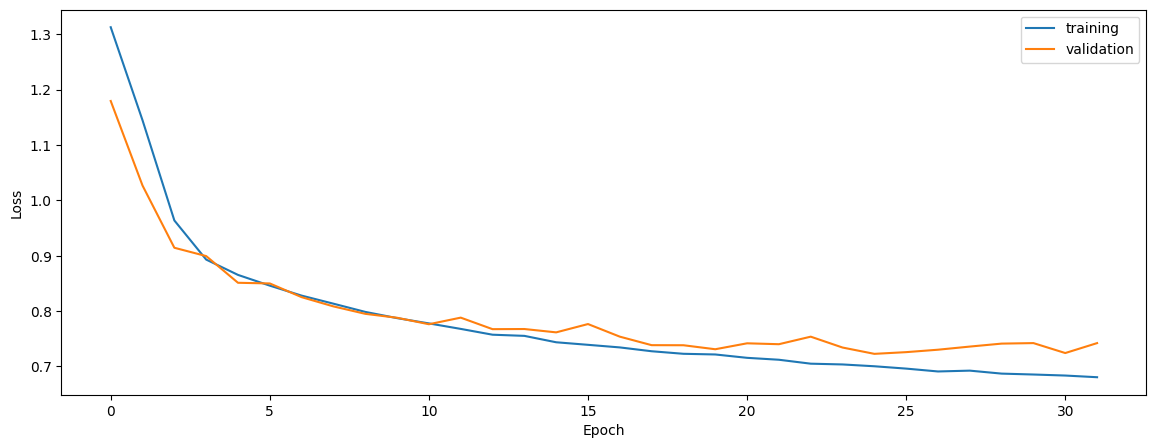

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


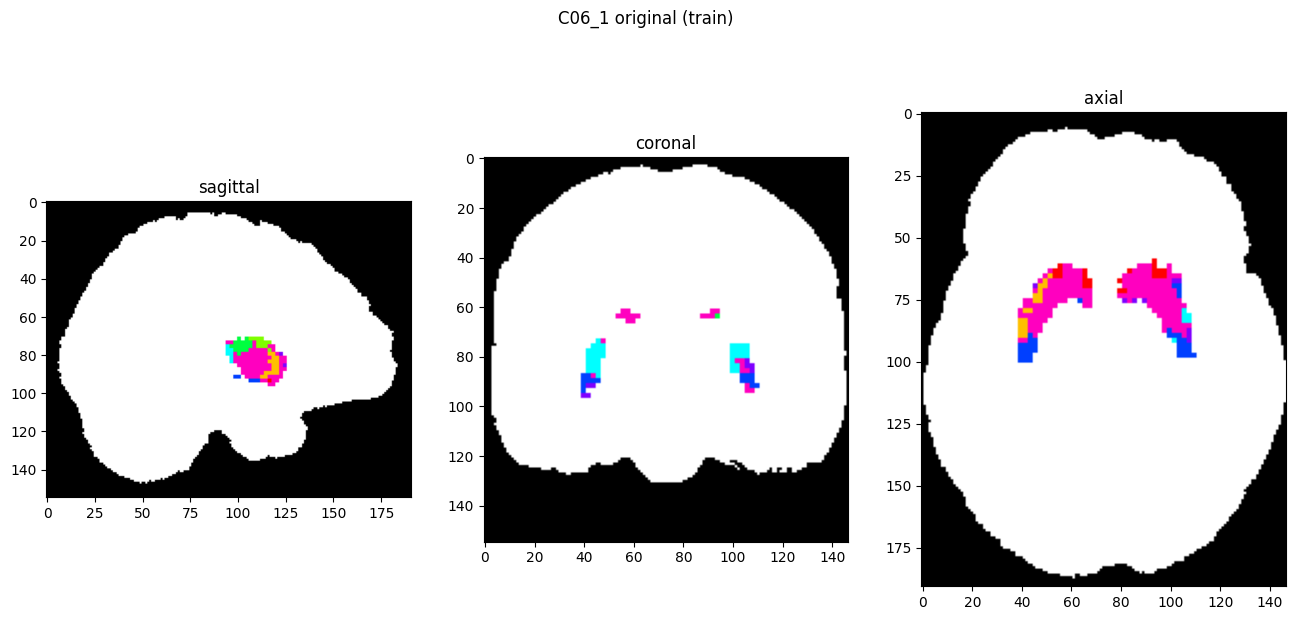

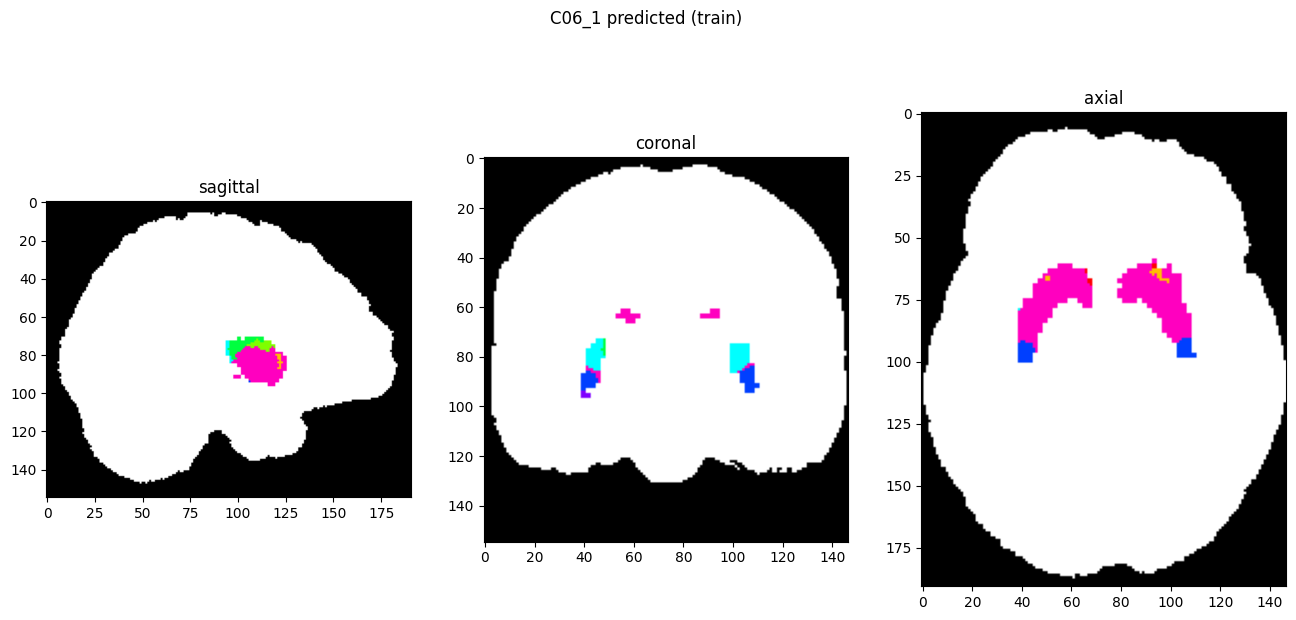

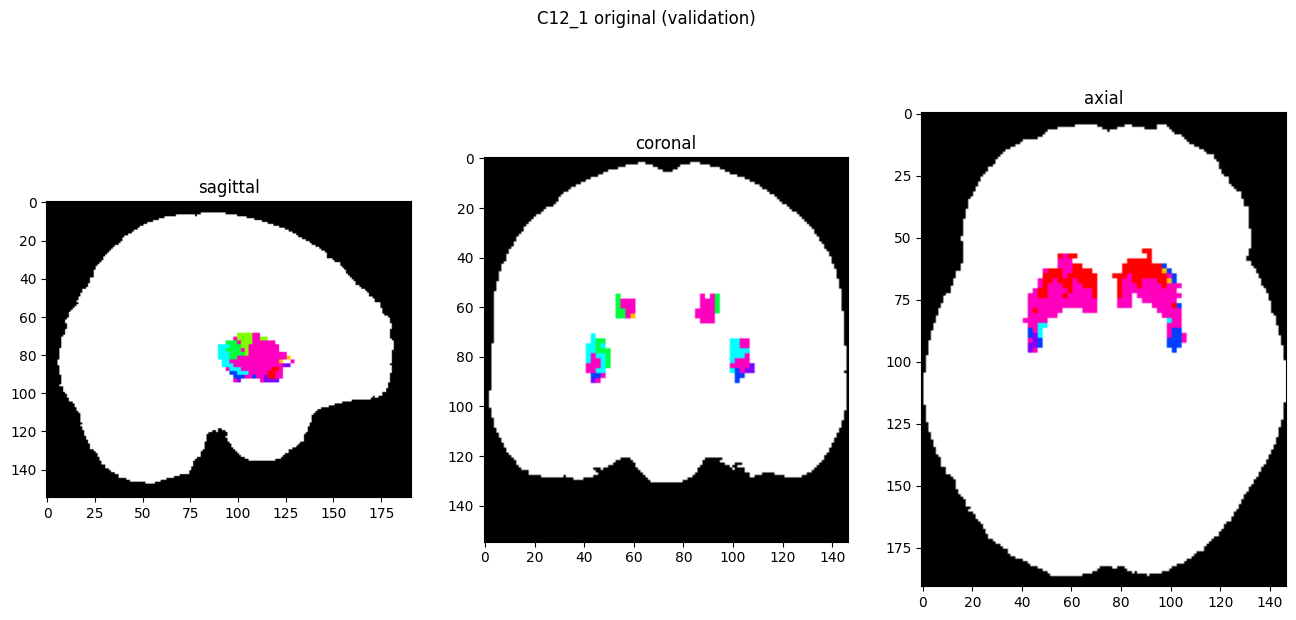

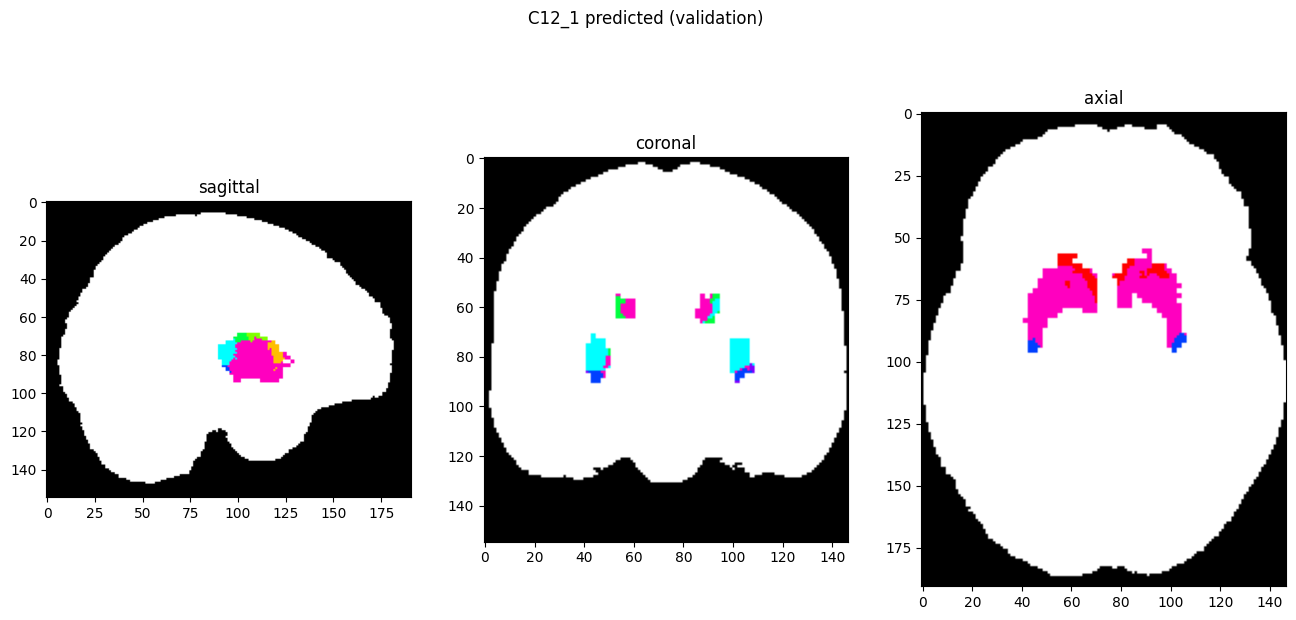

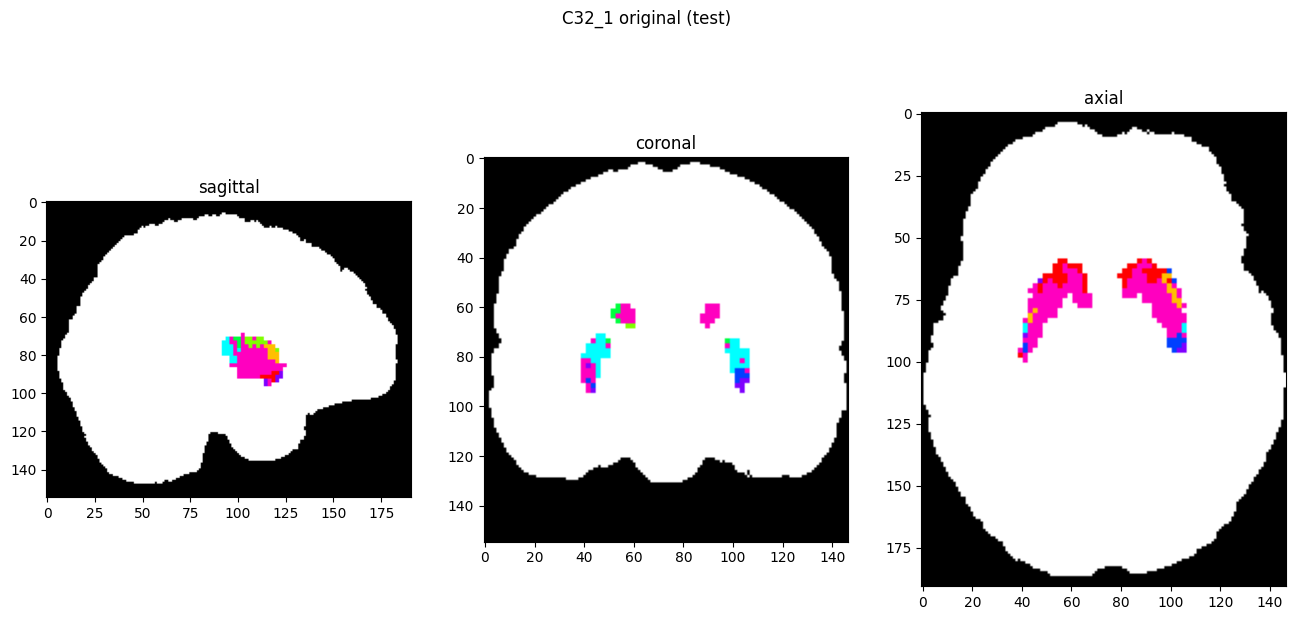

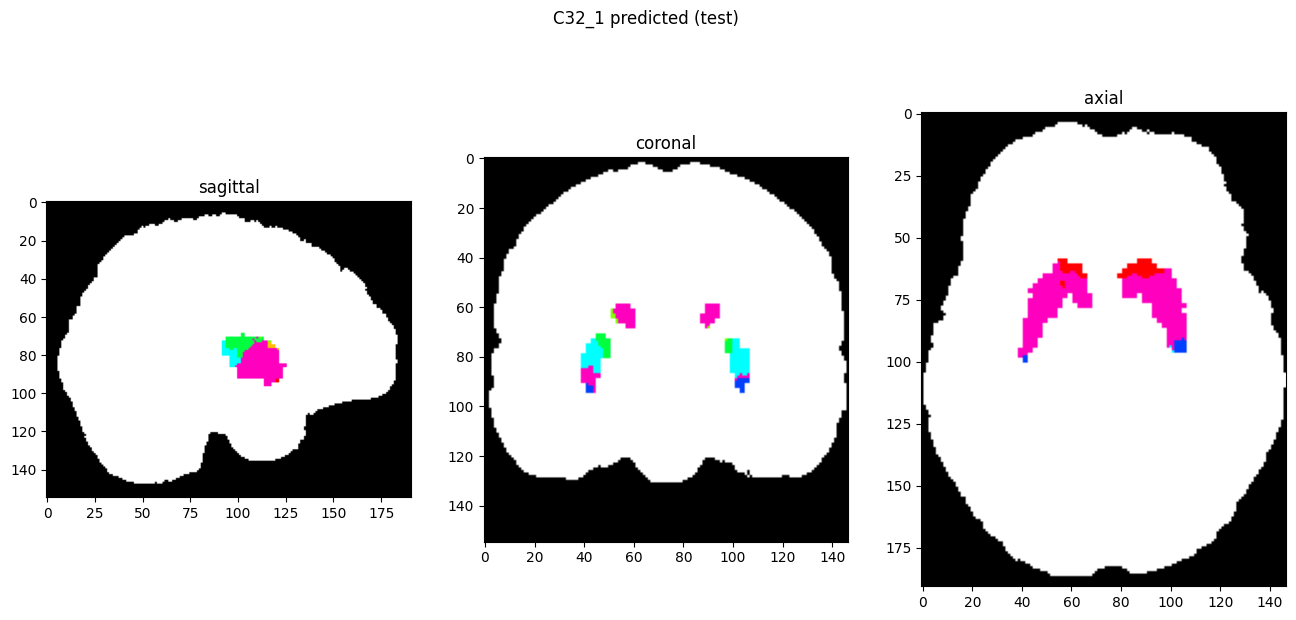

In [10]:
showResults(model, gen, threshold=0)